# Colab FAQ

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the colab GPU for this assignmentby selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Setup PyTorch
All files are stored at /content/csc421/a3/ folder


In [1]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install torch torchvision
!pip install Pillow==4.0.0
%mkdir -p ./content/csc421/a3/
%cd ./content/csc421/a3

     |████████████████████████████████| 11.1MB 19.0MB/s 
     |████████████████████████████████| 112kB 53.5MB/s 
  Created wheel for Pillow: filename=Pillow-4.0.0-cp37-cp37m-linux_x86_64.whl size=1007311 sha256=925775274eb74b37168b2462057f20d111706b02531bf4d4d0a41bf43baf9f7f
  Stored in directory: /root/.cache/pip/wheels/4f/0a/2a/7e3391063af230fac4b5fdb4cc93adcb1d99af325b623cea03
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=4688316bd47f4fb89d231cfd88e04db797f63247e9b032cc5be84908ab323acc
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built Pillow olefile
ERROR: torchvision 0.9.0+cu101 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 w

/content/content/csc421/a3


# Helper code

## Utility functions

In [2]:
import os
import pdb
import argparse
import pickle as pkl

from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from six.moves.urllib.request import urlretrieve
import tarfile
import pickle
import sys


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
def to_var(tensor, cuda):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

        Arguments:
            tensor: A Tensor object.
            cuda: A boolean flag indicating whether to use the GPU.

        Returns:
            A Variable object, on the GPU if cuda==True.
    """
    if cuda:
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


def create_dir_if_not_exists(directory):
    """Creates a directory if it doesn't already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)


def save_loss_plot(train_losses, val_losses, opts):
    """Saves a plot of the training and validation loss curves.
    """
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(val_losses)), val_losses)
    plt.title('BS={}, nhid={}'.format(opts.batch_size, opts.hidden_size), fontsize=20)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(opts.checkpoint_path, 'loss_plot.pdf'))
    plt.close()


def save_loss_comparison_lstm(l1, l2, o1, o2, fn, s=500):
    """Plot comparison of training and val loss curves from LSTM runs.
    
    Arguments:
        l1: Tuple of lists containing training / val losses for model 1.
        l2: Tuple of lists containing training / val losses for model 2.
        o1: Options for model 1.
        o2: Options for model 2.
        fn: Output file name.
        s: Number of training iterations to average over.
    """
    mean_l1 = [np.mean(l1[0][i*s:(i+1)*s]) for i in range(len(l1[0]) // s)]
    mean_l2 = [np.mean(l2[0][i*s:(i+1)*s]) for i in range(len(l2[0]) // s)]

    plt.figure()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(range(len(mean_l1)), mean_l1, label='ds=' + o1.data_file_name)
    ax[0].plot(range(len(mean_l2)), mean_l2, label='ds=' + o2.data_file_name)
    ax[0].title.set_text('Train Loss | LSTM Hidden Size = {}'.format(o2.hidden_size))

    # Validation losses are assumed to be by epoch
    ax[1].plot(range(len(l1[1])), l1[1], label='ds=' + o1.data_file_name)
    ax[1].plot(range(len(l2[1])), l2[1], label='ds=' + o2.data_file_name)
    ax[1].title.set_text('Val Loss | LSTM Hidden Size = {}'.format(o2.hidden_size))

    ax[0].set_xlabel("Iterations (x{})".format(s), fontsize=10)
    ax[0].set_ylabel("Loss", fontsize=10)
    ax[1].set_xlabel("Epochs", fontsize=10)
    ax[1].set_ylabel("Loss", fontsize=10)
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="upper right")

    fig.suptitle('LSTM Performance by Dataset', fontsize=14)
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.legend()
    plt.savefig('./loss_plot_{}.pdf'.format(fn))
    plt.close()


def save_loss_comparison_by_dataset(l1, l2, l3, l4, o1, o2, o3, o4, fn, s=500):
    """Plot comparison of training and validation loss curves from all four
    runs in Part 3, comparing by dataset while holding hidden size constant.

    Models within each pair (l1, l2) and (l3, l4) have the same hidden sizes.

    Arguments:
        l1: Tuple of lists containing training / val losses for model 1.
        l2: Tuple of lists containing training / val losses for model 2.
        l3: Tuple of lists containing training / val losses for model 3.
        l4: Tuple of lists containing training / val losses for model 4.
        o1: Options for model 1.
        o2: Options for model 2.
        o3: Options for model 3.
        o4: Options for model 4.
        fn: Output file name.
        s: Number of training iterations to average over.
    """
    mean_l1 = [np.mean(l1[0][i*s:(i+1)*s]) for i in range(len(l1[0]) // s)]
    mean_l2 = [np.mean(l2[0][i*s:(i+1)*s]) for i in range(len(l2[0]) // s)]
    mean_l3 = [np.mean(l3[0][i*s:(i+1)*s]) for i in range(len(l3[0]) // s)]
    mean_l4 = [np.mean(l4[0][i*s:(i+1)*s]) for i in range(len(l4[0]) // s)]

    plt.figure()
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    ax[0][0].plot(range(len(mean_l1)), mean_l1, label='ds=' + o1.data_file_name)
    ax[0][0].plot(range(len(mean_l2)), mean_l2, label='ds=' + o2.data_file_name)
    ax[0][0].title.set_text('Train Loss | Model Hidden Size = {}'.format(o1.hidden_size))

    # Validation losses are assumed to be by epoch
    ax[0][1].plot(range(len(l1[1])), l1[1], label='ds=' + o1.data_file_name)
    ax[0][1].plot(range(len(l2[1])), l2[1], label='ds=' + o2.data_file_name)
    ax[0][1].title.set_text('Val Loss | Model Hidden Size = {}'.format(o1.hidden_size))

    ax[1][0].plot(range(len(mean_l3)), mean_l3, label='ds=' + o3.data_file_name)
    ax[1][0].plot(range(len(mean_l4)), mean_l4, label='ds=' + o4.data_file_name)
    ax[1][0].title.set_text('Train Loss | Model Hidden Size = {}'.format(o3.hidden_size))

    ax[1][1].plot(range(len(l3[1])), l3[1], label='ds=' + o3.data_file_name)
    ax[1][1].plot(range(len(l4[1])), l4[1], label='ds=' + o4.data_file_name)
    ax[1][1].title.set_text('Val Loss | Model Hidden Size = {}'.format(o4.hidden_size))

    for i in range(2):
        ax[i][0].set_xlabel("Iterations (x{})".format(s), fontsize=10)
        ax[i][0].set_ylabel("Loss", fontsize=10)
        ax[i][1].set_xlabel("Epochs", fontsize=10)
        ax[i][1].set_ylabel("Loss", fontsize=10)
        ax[i][0].legend(loc="upper right")
        ax[i][1].legend(loc="upper right")

    fig.suptitle("Performance by Dataset Size", fontsize=16)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.legend()
    plt.savefig('./loss_plot_{}.pdf'.format(fn))
    plt.close()

def save_loss_comparison_by_hidden(l1, l2, l3, l4, o1, o2, o3, o4, fn, s=500):
    """Plot comparison of training and validation loss curves from all four
    runs in Part 3, comparing by hidden size while holding dataset constant.

    Models within each pair (l1, l3) and (l2, l4) have the same dataset.

    Arguments:
        l1: Tuple of lists containing training / val losses for model 1.
        l2: Tuple of lists containing training / val losses for model 2.
        l3: Tuple of lists containing training / val losses for model 3.
        l4: Tuple of lists containing training / val losses for model 4.
        o1: Options for model 1.
        o2: Options for model 2.
        o3: Options for model 3.
        o4: Options for model 4.
        fn: Output file name.
        s: Number of training iterations to average over.
    """
    mean_l1 = [np.mean(l1[0][i*s:(i+1)*s]) for i in range(len(l1[0]) // s)]
    mean_l2 = [np.mean(l2[0][i*s:(i+1)*s]) for i in range(len(l2[0]) // s)]
    mean_l3 = [np.mean(l3[0][i*s:(i+1)*s]) for i in range(len(l3[0]) // s)]
    mean_l4 = [np.mean(l4[0][i*s:(i+1)*s]) for i in range(len(l4[0]) // s)]

    plt.figure()
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    ax[0][0].plot(range(len(mean_l1)), mean_l1, label='hid_size=' + str(o1.hidden_size))
    ax[0][0].plot(range(len(mean_l3)), mean_l3, label='hid_size=' + str(o3.hidden_size))
    ax[0][0].title.set_text('Train Loss | Dataset = ' + o1.data_file_name)

    # Validation losses are assumed to be by epoch
    ax[0][1].plot(range(len(l1[1])), l1[1], label='hid_size=' + str(o1.hidden_size))
    ax[0][1].plot(range(len(l3[1])), l3[1], label='hid_size=' + str(o3.hidden_size))
    ax[0][1].title.set_text('Val Loss | Dataset = ' + o1.data_file_name)

    ax[1][0].plot(range(len(mean_l2)), mean_l2, label='hid_size=' + str(o2.hidden_size))
    ax[1][0].plot(range(len(mean_l4)), mean_l4, label='hid_size=' + str(o4.hidden_size))
    ax[1][0].title.set_text('Train Loss | Dataset = ' + o3.data_file_name)

    ax[1][1].plot(range(len(l2[1])), l2[1], label='hid_size=' + str(o2.hidden_size))
    ax[1][1].plot(range(len(l4[1])), l4[1], label='hid_size=' + str(o4.hidden_size))
    ax[1][1].title.set_text('Val Loss | Dataset = ' + o4.data_file_name)

    for i in range(2):
        ax[i][0].set_xlabel("Iterations (x{})".format(s), fontsize=10)
        ax[i][0].set_ylabel("Loss", fontsize=10)
        ax[i][1].set_xlabel("Epochs", fontsize=10)
        ax[i][1].set_ylabel("Loss", fontsize=10)
        ax[i][0].legend(loc="upper right")
        ax[i][1].legend(loc="upper right")

    fig.suptitle("Performance by Hidden State Size", fontsize=16)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.legend()
    plt.savefig('./loss_plot_{}.pdf'.format(fn))
    plt.close()


def checkpoint(encoder, decoder, idx_dict, opts):
    """Saves the current encoder and decoder models, along with idx_dict, which
    contains the char_to_index and index_to_char mappings, and the start_token
    and end_token values.
    """
    with open(os.path.join(opts.checkpoint_path, 'encoder.pt'), 'wb') as f:
        torch.save(encoder, f)

    with open(os.path.join(opts.checkpoint_path, 'decoder.pt'), 'wb') as f:
        torch.save(decoder, f)

    with open(os.path.join(opts.checkpoint_path, 'idx_dict.pkl'), 'wb') as f:
        pkl.dump(idx_dict, f)


## Data loader

In [3]:
def read_lines(filename):
    """Read a file and split it into lines.
    """
    lines = open(filename).read().strip().lower().split('\n')
    return lines


def read_pairs(filename):
    """Reads lines that consist of two words, separated by a space.

    Returns:
        source_words: A list of the first word in each line of the file.
        target_words: A list of the second word in each line of the file.
    """
    lines = read_lines(filename)
    source_words, target_words = [], []
    for line in lines:
        line = line.strip()
        if line:
            source, target = line.split()
            source_words.append(source)
            target_words.append(target)
    return source_words, target_words


def all_alpha_or_dash(s):
    """Helper function to check whether a string is alphabetic, allowing dashes '-'.
    """
    return all(c.isalpha() or c == '-' for c in s)


def filter_lines(lines):
    """Filters lines to consist of only alphabetic characters or dashes "-".
    """
    return [line for line in lines if all_alpha_or_dash(line)]


def load_data(file_name):
    """Loads (English, Pig-Latin) word pairs, and creates mappings from characters to indexes.
    """
    path = "./data/{}.txt".format(file_name)
    source_lines, target_lines = read_pairs(path)

    # Filter lines
    source_lines = filter_lines(source_lines)
    target_lines = filter_lines(target_lines)

    all_characters = set(''.join(source_lines)) | set(''.join(target_lines))

    # Create a dictionary mapping each character to a unique index
    char_to_index = { char: index for (index, char) in enumerate(sorted(list(all_characters))) }

    # Add start and end tokens to the dictionary
    start_token = len(char_to_index)
    end_token = len(char_to_index) + 1
    char_to_index['SOS'] = start_token
    char_to_index['EOS'] = end_token

    # Create the inverse mapping, from indexes to characters (used to decode the model's predictions)
    index_to_char = { index: char for (char, index) in char_to_index.items() }

    # Store the final size of the vocabulary
    vocab_size = len(char_to_index)

    line_pairs = list(set(zip(source_lines, target_lines)))  # Python 3

    idx_dict = { 'char_to_index': char_to_index,
                 'index_to_char': index_to_char,
                 'start_token': start_token,
                 'end_token': end_token }

    return line_pairs, vocab_size, idx_dict


def create_dict(pairs):
    """Creates a mapping { (source_length, target_length): [list of (source, target) pairs]
    This is used to make batches: each batch consists of two parallel tensors, one containing
    all source indexes and the other containing all corresponding target indexes.
    Within a batch, all the source words are the same length, and all the target words are
    the same length.
    """
    unique_pairs = list(set(pairs))  # Find all unique (source, target) pairs

    d = defaultdict(list)
    for (s,t) in unique_pairs:
        d[(len(s), len(t))].append((s,t))

    return d


## Training and evaluation code

In [4]:
def string_to_index_list(s, char_to_index, end_token):
    """Converts a sentence into a list of indexes (for each character).
    """
    return [char_to_index[char] for char in s] + [end_token]  # Adds the end token to each index list


def translate_sentence(sentence, encoder, decoder, idx_dict, opts):
    """Translates a sentence from English to Pig-Latin, by splitting the sentence into
    words (whitespace-separated), running the encoder-decoder model to translate each
    word independently, and then stitching the words back together with spaces between them.
    """
    if idx_dict is None:
      line_pairs, vocab_size, idx_dict = load_data(opts['data_file_name'])
    return ' '.join([translate(word, encoder, decoder, idx_dict, opts) for word in sentence.split()])


def translate(input_string, encoder, decoder, idx_dict, opts):
    """Translates a given string from English to Pig-Latin.
    """

    char_to_index = idx_dict['char_to_index']
    index_to_char = idx_dict['index_to_char']
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']

    max_generated_chars = 20
    gen_string = ''

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(torch.LongTensor(indexes).unsqueeze(0), opts.cuda)  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_last_hidden, encoder_last_cell = encoder(indexes)

    decoder_hidden = encoder_last_hidden
    decoder_cell = encoder_last_cell
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    for i in range(max_generated_chars):
        ## slow decoding, recompute everything at each time
        decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden, decoder_cell)

        generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
        ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
        ni = ni[-1] #latest output token

        decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)

        if ni == end_token:
            break
        else:
            gen_string = "".join(
                [index_to_char[int(item)] 
                for item in generated_words.cpu().numpy().reshape(-1)])

    return gen_string


def visualize_attention(input_string, encoder, decoder, idx_dict, opts):
    """Generates a heatmap to show where attention is focused in each decoder step.
    """
    if idx_dict is None:
      line_pairs, vocab_size, idx_dict = load_data(opts['data_file_name'])
    char_to_index = idx_dict['char_to_index']
    index_to_char = idx_dict['index_to_char']
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']

    max_generated_chars = 20
    gen_string = ''

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(torch.LongTensor(indexes).unsqueeze(0), opts.cuda)  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_hidden, encoder_cell = encoder(indexes)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    produced_end_token = False

    for i in range(max_generated_chars):
        ## slow decoding, recompute everything at each time
        decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden, decoder_cell)
        generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
        ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
        ni = ni[-1] #latest output token

        decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)

        if ni == end_token:
            break
        else:
            gen_string = "".join(
                [index_to_char[int(item)] 
                for item in generated_words.cpu().numpy().reshape(-1)])
    
    if isinstance(attention_weights, tuple):
      ## transformer's attention mweights
      attention_weights, self_attention_weights = attention_weights
    
    all_attention_weights = attention_weights.data.cpu().numpy()
    
    for i in range(len(all_attention_weights)):
        attention_weights_matrix = all_attention_weights[i].squeeze()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(attention_weights_matrix, cmap='bone')
        fig.colorbar(cax)

        # Set up axes
        ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
        ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        # Add title
        plt.xlabel('Attention weights to the source sentence in layer {}'.format(i+1))
        plt.tight_layout()
        plt.grid('off')
        plt.show()

    return gen_string


def compute_loss(data_dict, encoder, decoder, idx_dict, criterion, optimizer, opts):
    """Train/Evaluate the model on a dataset.

    Arguments:
        data_dict: The validation/test word pairs, organized by source and target lengths.
        encoder: An encoder model to produce annotations for each step of the input sequence.
        decoder: A decoder model (with or without attention) to generate output tokens.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Train the weights if an optimizer is given. None if only evaluate the model. 
        opts: The command-line arguments.

    Returns:
        mean_loss: The average loss over all batches from data_dict.
    """
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    losses = []
    for key in data_dict:
        input_strings, target_strings = zip(*data_dict[key])
        input_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in input_strings]
        target_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in target_strings]

        num_tensors = len(input_tensors)
        num_batches = int(np.ceil(num_tensors / float(opts.batch_size)))

        for i in range(num_batches):

            start = i * opts.batch_size
            end = start + opts.batch_size

            inputs = to_var(torch.stack(input_tensors[start:end]), opts.cuda)
            targets = to_var(torch.stack(target_tensors[start:end]), opts.cuda)

            # The batch size may be different in each epoch
            BS = inputs.size(0)

            encoder_annotations, encoder_hidden, encoder_cell = encoder(inputs)

            # The last hidden state of the encoder becomes the first hidden state of the decoder
            decoder_hidden = encoder_hidden
            decoder_cell = encoder_cell

            start_vector = torch.ones(BS).long().unsqueeze(1) * start_token  # BS x 1 --> 16x1  CHECKED
            decoder_input = to_var(start_vector, opts.cuda)  # BS x 1 --> 16x1  CHECKED

            loss = 0.0

            seq_len = targets.size(1)  # Gets seq_len from BS x seq_len

            decoder_inputs = torch.cat([decoder_input, targets[:, 0:-1]], dim=1)  # Gets decoder inputs by shifting the targets to the right 

            decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden, decoder_cell)
            decoder_outputs_flatten = decoder_outputs.view(-1, decoder_outputs.size(2))
            targets_flatten = targets.view(-1)
            
            loss = criterion(decoder_outputs_flatten, targets_flatten)

            losses.append(loss.item())

            ## training if an optimizer is provided
            if optimizer:
              # Zero gradients
              optimizer.zero_grad()
              # Compute gradients
              loss.backward()
              # Update the parameters of the encoder and decoder
              optimizer.step()

    return losses

  

def training_loop(train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts):
    """Runs the main training loop; evaluates the model on the val set every epoch.
        * Prints training and val loss each epoch.
        * Prints qualitative translation results each epoch using TEST_SENTENCE
        * Saves an attention map for TEST_WORD_ATTN each epoch
        * Returns loss curves for comparison

    Arguments:
        train_dict: The training word pairs, organized by source and target lengths.
        val_dict: The validation word pairs, organized by source and target lengths.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        encoder: An encoder model to produce annotations for each step of the input sequence.
        decoder: A decoder model (with or without attention) to generate output tokens.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Implements a step rule to update the parameters of the encoder and decoder.
        opts: The command-line arguments.
    
    Returns:
        losses: Lists containing training and validation loss curves.
    """

    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    loss_log = open(os.path.join(opts.checkpoint_path, 'loss_log.txt'), 'w')

    best_val_loss = 1e6
    train_losses = []
    val_losses = []
    
    mean_train_losses = []
    mean_val_losses = []

    early_stopping_counter = 0
    
    for epoch in range(opts.nepochs):

        optimizer.param_groups[0]['lr'] *= opts.lr_decay
        
        train_loss = compute_loss(train_dict, encoder, decoder, idx_dict, criterion, optimizer, opts)
        val_loss = compute_loss(val_dict, encoder, decoder, idx_dict, criterion, None, opts)

        mean_train_loss = np.mean(train_loss)
        mean_val_loss = np.mean(val_loss)

        if mean_val_loss < best_val_loss:
            checkpoint(encoder, decoder, idx_dict, opts)
            best_val_loss = mean_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter > opts.early_stopping_patience:
            print("Validation loss has not improved in {} epochs, stopping early".format(opts.early_stopping_patience))
            print("Obtained lowest validation loss of: {}".format(best_val_loss))
            return (train_losses, mean_val_losses)

        gen_string = translate_sentence(TEST_SENTENCE, encoder, decoder, idx_dict, opts)
        print("Epoch: {:3d} | Train loss: {:.3f} | Val loss: {:.3f} | Gen: {:20s}".format(epoch, mean_train_loss, mean_val_loss, gen_string))

        loss_log.write('{} {} {}\n'.format(epoch, train_loss, val_loss))
        loss_log.flush()

        train_losses += train_loss
        val_losses += val_loss

        mean_train_losses.append(mean_train_loss)
        mean_val_losses.append(mean_val_loss)

        save_loss_plot(mean_train_losses, mean_val_losses, opts)

    print("Obtained lowest validation loss of: {}".format(best_val_loss))
    return (train_losses, mean_val_losses)


def print_data_stats(line_pairs, vocab_size, idx_dict):
    """Prints example word pairs, the number of data points, and the vocabulary.
    """
    print('=' * 80)
    print('Data Stats'.center(80))
    print('-' * 80)
    for pair in line_pairs[:5]:
        print(pair)
    print('Num unique word pairs: {}'.format(len(line_pairs)))
    print('Vocabulary: {}'.format(idx_dict['char_to_index'].keys()))
    print('Vocab size: {}'.format(vocab_size))
    print('=' * 80)


def train(opts):
    line_pairs, vocab_size, idx_dict = load_data(opts['data_file_name'])
    print_data_stats(line_pairs, vocab_size, idx_dict)

    # Split the line pairs into an 80% train and 20% val split
    num_lines = len(line_pairs)
    num_train = int(0.8 * num_lines)
    train_pairs, val_pairs = line_pairs[:num_train], line_pairs[num_train:]

    # Group the data by the lengths of the source and target words, to form batches
    train_dict = create_dict(train_pairs)
    val_dict = create_dict(val_pairs)

    ##########################################################################
    ### Setup: Create Encoder, Decoder, Learning Criterion, and Optimizers ###
    ##########################################################################
    if opts.encoder_type == "rnn":
        encoder = LSTMEncoder(vocab_size=vocab_size, 
                              hidden_size=opts.hidden_size, 
                              opts=opts)
    elif opts.encoder_type == "transformer":
        encoder = TransformerEncoder(vocab_size=vocab_size, 
                                     hidden_size=opts.hidden_size, 
                                     num_layers=opts.num_transformer_layers,
                                     opts=opts)
    else:
        raise NotImplementedError

    if opts.decoder_type == 'rnn':
        decoder = RNNDecoder(vocab_size=vocab_size, 
                             hidden_size=opts.hidden_size)
    elif opts.decoder_type == 'rnn_attention':
        decoder = RNNAttentionDecoder(vocab_size=vocab_size, 
                                      hidden_size=opts.hidden_size, 
                                      attention_type=opts.attention_type)
    elif opts.decoder_type == 'transformer':
        decoder = TransformerDecoder(vocab_size=vocab_size, 
                                     hidden_size=opts.hidden_size, 
                                     num_layers=opts.num_transformer_layers)
    else:
        raise NotImplementedError
        
    #### setup checkpoint path
    model_name = 'h{}-bs{}-{}-{}'.format(opts.hidden_size, 
                                      opts.batch_size, 
                                      opts.decoder_type,
                                      opts.data_file_name)
    opts.checkpoint_path = model_name
    create_dir_if_not_exists(opts.checkpoint_path)
    ####

    if opts.cuda:
        encoder.cuda()
        decoder.cuda()
        print("Moved models to GPU!")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=opts.learning_rate)

    try:
        losses = training_loop(train_dict, val_dict, idx_dict, encoder, 
                               decoder, criterion, optimizer, opts)
    except KeyboardInterrupt:
        print('Exiting early from training.')
        return encoder, decoder, losses
      
    return encoder, decoder, losses


def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)


## Download dataset

In [5]:
######################################################################
# Download Translation datasets
######################################################################
data_fpath = get_file(fname='pig_latin_small.txt', 
                         origin='http://www.cs.toronto.edu/~jba/pig_latin_small.txt', 
                         untar=False)

data_fpath = get_file(fname='pig_latin_large.txt', 
                         origin='http://www.cs.toronto.edu/~jba/pig_latin_large.txt', 
                         untar=False)

data/pig_latin_small.txt
data/pig_latin_large.txt


# Part 1: Long Short-Term Memory Unit (LSTM)

## Step 1: LSTM Cell
Please implement the Long Short-Term Memory class defined in the next cell. 

In [6]:
class MyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # ------------
        # FILL THIS IN
        # ------------
        self.Wii = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size)

        self.Wif = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size)

        self.Wig = nn.Linear(input_size, hidden_size)
        self.Whg = nn.Linear(hidden_size, hidden_size)

        self.Wio = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size)


    def forward(self, x, h_prev, c_prev):
        """Forward pass of the LSTM computation for one time step.

        Arguments
            x: batch_size x input_size
            h_prev: batch_size x hidden_size
            c_prev: batch_size x hidden_size

        Returns:
            h_new: batch_size x hidden_size
            c_new: batch_size x hidden_size
        """

        # ------------
        # FILL THIS IN
        # ------------
        i = torch.sigmoid(torch.add(self.Wii(x), self.Whi(h_prev)))
        f = torch.sigmoid(torch.add(self.Wif(x), self.Whf(h_prev)))
        g = torch.tanh(torch.add(self.Wig(x), self.Whg(h_prev)))
        o = torch.sigmoid(torch.add(self.Wio(x), self.Who(h_prev)))
        c_new = torch.add(torch.mul(f,c_prev), torch.mul(i, g))
        h_new = torch.mul(o, torch.tanh(c_new))
        return h_new, c_new

## Step 2: LSTM Encoder
Please inspect the following recurrent encoder/decoder implementations. Make sure to run the cells before proceeding. 

In [7]:
class LSTMEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, opts):
        super(LSTMEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.opts = opts

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = MyLSTMCell(hidden_size, hidden_size)

    def forward(self, inputs):
        """Forward pass of the encoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all time steps in the sequence. (batch_size x seq_len)

        Returns:
            annotations: The hidden states computed at each step of the input sequence. (batch_size x seq_len x hidden_size)
            hidden: The final hidden state of the encoder, for each sequence in a batch. (batch_size x hidden_size)
        """

        batch_size, seq_len = inputs.size()
        hidden = self.init_hidden(batch_size)
        cell = self.init_hidden(batch_size)

        encoded = self.embedding(inputs)  # batch_size x seq_len x hidden_size
        annotations = []

        for i in range(seq_len):
            x = encoded[:,i,:]  # Get the current time step, across the whole batch
            hidden, cell = self.lstm(x, hidden, cell)
            annotations.append(hidden)

        annotations = torch.stack(annotations, dim=1)
        return annotations, hidden, cell

    def init_hidden(self, bs):
        """Creates a tensor of zeros to represent the initial hidden states
        of a batch of sequences.

        Arguments:
            bs: The batch size for the initial hidden state.

        Returns:
            hidden: An initial hidden state of all zeros. (batch_size x hidden_size)
        """
        return to_var(torch.zeros(bs, self.hidden_size), self.opts.cuda)

In [8]:
class RNNDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(RNNDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = MyLSTMCell(input_size=hidden_size, hidden_size=hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, annotations, hidden_init, cell_init):
        """Forward pass of the non-attentional decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch. (batch_size x seq_len)
            annotations: This is not used here. It just maintains consistency with the
                    interface used by the AttentionDecoder class.
            hidden_init: The hidden states from the last step of encoder, across a batch. (batch_size x hidden_size)
            cell_init: The cell states from the last step of encoder, across a batch. (batch_size x hidden_size)

        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            None
        """        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size        

        hiddens = []
        h_prev = hidden_init
        c_prev = cell_init

        for i in range(seq_len):
            x = embed[:,i,:]  # Get the current time step input tokens, across the whole batch
            h_prev, c_prev = self.rnn(x, h_prev, c_prev)  # batch_size x hidden_size
            hiddens.append(h_prev)

        hiddens = torch.stack(hiddens, dim=1) # batch_size x seq_len x hidden_size
        
        output = self.out(hiddens)  # batch_size x seq_len x vocab_size
        return output, None  

## Step 3: Training and Analysis
Train the following language model comprised of recurrent encoder and decoders. 

First, we train on the smaller dataset.

In [9]:
TEST_SENTENCE = 'the air conditioning is working'

rnn_args_s = AttrDict()
args_dict = {
              'data_file_name': 'pig_latin_small',
              'cuda':True,
              'nepochs':50,
              'checkpoint_dir':"checkpoints",
              'learning_rate':0.005,
              'lr_decay':0.99,
              'early_stopping_patience':20,
              'batch_size':64,
              'hidden_size':32,
              'encoder_type': 'rnn', # options: rnn / transformer
              'decoder_type': 'rnn', # options: rnn / rnn_attention / transformer
              'attention_type': '',  # options: additive / scaled_dot
}
rnn_args_s.update(args_dict)

print_opts(rnn_args_s)
rnn_encode_s, rnn_decoder_s, rnn_losses_s = train(rnn_args_s)

translated = translate_sentence(TEST_SENTENCE, rnn_encode_s, rnn_decoder_s, None, rnn_args_s)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.005                                  
                               lr_decay: 0.99                                   
                early_stopping_patience: 20                                     
                             batch_size: 64                                     
                            hidden_size: 32                                     
                           encoder_type: rnn                                    
                           d

Next, we train on the larger dataset. This experiment investigates if increasing dataset size improves model generalization on the validation set. 

For a fair comparison, the number of iterations (not number of epochs) for each run should be similar. This is done in a rough and dirty way by adjusting the batch size so approximately the same number of batches is processed per epoch.

In [10]:
TEST_SENTENCE = 'the air conditioning is working'

rnn_args_l = AttrDict()
args_dict = {
              'data_file_name': 'pig_latin_large',
              'cuda':True,
              'nepochs':50,
              'checkpoint_dir':"checkpoints",
              'learning_rate':0.005,
              'lr_decay':0.99,
              'early_stopping_patience':10,
              'batch_size':512,
              'hidden_size':32,
              'encoder_type': 'rnn', # options: rnn / transformer
              'decoder_type': 'rnn', # options: rnn / rnn_attention / transformer
              'attention_type': '',  # options: additive / scaled_dot
}
rnn_args_l.update(args_dict)

print_opts(rnn_args_l)
rnn_encode_l, rnn_decoder_l, rnn_losses_l = train(rnn_args_l)

translated = translate_sentence(TEST_SENTENCE, rnn_encode_l, rnn_decoder_l, None, rnn_args_l)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_large                        
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.005                                  
                               lr_decay: 0.99                                   
                early_stopping_patience: 10                                     
                             batch_size: 512                                    
                            hidden_size: 32                                     
                           encoder_type: rnn                                    
                           d

The code below plots the training and validation losses of each model, as a function of the number of gradient descent iterations. Consider if there are significant differences in the validation performance of each model.

In [11]:
save_loss_comparison_lstm(rnn_losses_s, rnn_losses_l, rnn_args_s, rnn_args_l, 'lstm')

<Figure size 432x288 with 0 Axes>

Select best performing model, and try translating different sentences by changing the variable TEST_SENTENCE. Identify a failure mode and briefly describe it.

In [12]:
best_encoder = rnn_encode_l # Replace with rnn_losses_s or rnn_losses_l
best_decoder = rnn_decoder_l # etc.
best_args = rnn_args_l

TEST_SENTENCE = 'the air conditioning is working'
translated = translate_sentence(TEST_SENTENCE, best_encoder, best_decoder, None, best_args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the air conditioning is working 
translated:	ethay airway ondingichay-onway isway orkingway


In [13]:
TEST_SENTENCE_2 = 'this beautiful shopping mall'
translated_2 = translate_sentence(TEST_SENTENCE_2, best_encoder, best_decoder, None, best_args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE_2, translated_2))

source:		this beautiful shopping mall 
translated:	isthay eautuinsway oppingspay allmay


In [14]:
TEST_SENTENCE_3 = 'extremely happy ending'
translated_3 = translate_sentence(TEST_SENTENCE_3, best_encoder, best_decoder, None, best_args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE_3, translated_3))

source:		extremely happy ending 
translated:	exterledgway apphyay endingway


In [15]:
TEST_SENTENCE_4 = 'go to school now'
translated_4 = translate_sentence(TEST_SENTENCE_4, best_encoder, best_decoder, None, best_args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE_4, translated_4))

source:		go to school now 
translated:	ogay otay oolcepay ownay


# Part 2: Additive Attention

## Step 1: Additive Attention
Already implemented the additive attention mechanism. Write down the mathematical expression for $\tilde{\alpha}_i^{(t)}, \alpha_i^{(t)}, c_t$ as a function of $W_1, W_2, b_1, b_2, Q_t, K_i$. 

In [16]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size):
        super(AdditiveAttention, self).__init__()

        self.hidden_size = hidden_size

        # A two layer fully-connected network
        # hidden_size*2 --> hidden_size, ReLU, hidden_size --> 1
        self.attention_network = nn.Sequential(
                                    nn.Linear(hidden_size*2, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1)
                                 )

        self.softmax = nn.Softmax(dim=1) #the seq_len dimension

    def forward(self, queries, keys, values):
        """The forward pass of the additive attention mechanism.

        Arguments:
            queries: The current decoder hidden state. (batch_size x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x 1 x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The attention_weights must be a softmax weighting over the seq_len annotations.
        """
        batch_size = keys.size(0)
        expanded_queries = queries.view(batch_size, -1, self.hidden_size).expand_as(keys) #-1: add one dimension in middle, expand_as: make it same shape as keys
        #print("expanded_queries:", expanded_queries.size())
        concat_inputs = torch.cat([expanded_queries, keys], dim=2) #concat along the dimension 2
        #print("concat_inputs:", concat_inputs.size())
        unnormalized_attention = self.attention_network(concat_inputs)
        #print("unnormalized_attention:",unnormalized_attention.size())
        attention_weights = self.softmax(unnormalized_attention)
        context = torch.bmm(attention_weights.transpose(2,1), values)
        return context, attention_weights
      

## Step 2: RNN Additive Attention Decoder
We will now implement a recurrent decoder that makes use of the additive attention mechanism. Read the description in the assignment worksheet and complete the following implementation. 

In [17]:
class RNNAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, attention_type='scaled_dot'):
        super(RNNAttentionDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.rnn = MyLSTMCell(input_size=hidden_size*2, hidden_size=hidden_size)
        if attention_type == 'additive':
          self.attention = AdditiveAttention(hidden_size=hidden_size)
        elif attention_type == 'scaled_dot':
          self.attention = ScaledDotAttention(hidden_size=hidden_size)
        
        self.out = nn.Linear(hidden_size, vocab_size)

        
    def forward(self, inputs, annotations, hidden_init, cell_init):
        """Forward pass of the attention-based decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
            annotations: The encoder hidden states for each step of the input.
                         sequence. (batch_size x seq_len x hidden_size)
            hidden_init: The final hidden states from the encoder, across a batch. (batch_size x hidden_size)
            cell_init: The final cell states from the encoder, across a batch. (batch_size x hidden_size)

        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """
        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size        

        hiddens = []
        attentions = []
        h_prev = hidden_init
        c_prev = cell_init

        for i in range(seq_len):
            embed_current = embed[:,i,:]  # Get the current time step, across the whole batch
            context, attention_weights = self.attention(h_prev, annotations, annotations)  # batch_size x 1 x hidden_size
            embed_and_context = torch.cat([embed_current, context.squeeze(1)], dim=1)  # batch_size x (2*hidden_size)
            h_prev, c_prev = self.rnn(embed_and_context, h_prev, c_prev)  # batch_size x hidden_size            
            
            
            hiddens.append(h_prev)
            attentions.append(attention_weights)

        hiddens = torch.stack(hiddens, dim=1) # batch_size x seq_len x hidden_size
        attentions = torch.cat(attentions, dim=2) # batch_size x seq_len x seq_len
        
        output = self.out(hiddens)  # batch_size x seq_len x vocab_size
        return output, attentions
        

## Step 3: Training and Analysis
Train the following language model that uses a recurrent encoder, and a recurrent decoder that has an additive attention component. 

In [18]:
TEST_SENTENCE = 'the air conditioning is working'

rnn_attn_args = AttrDict()
args_dict = {
              'data_file_name': 'pig_latin_small',
              'cuda':True, 
              'nepochs':50, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':0.005,
              'lr_decay':0.99,
              'early_stopping_patience':10,
              'batch_size':64, 
              'hidden_size':64, 
              'encoder_type': 'rnn', # options: rnn / transformer
              'decoder_type': 'rnn_attention', # options: rnn / rnn_attention / transformer
              'attention_type': 'additive',  # options: additive / scaled_dot
}
rnn_attn_args.update(args_dict)

print_opts(rnn_attn_args)
rnn_attn_encoder, rnn_attn_decoder, rnn_attn_losses = train(rnn_attn_args)

translated = translate_sentence(TEST_SENTENCE, rnn_attn_encoder, rnn_attn_decoder, None, rnn_attn_args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.005                                  
                               lr_decay: 0.99                                   
                early_stopping_patience: 10                                     
                             batch_size: 64                                     
                            hidden_size: 64                                     
                           encoder_type: rnn                                    
                           d

In [19]:
TEST_SENTENCE = 'the air conditioning is working'
translated = translate_sentence(TEST_SENTENCE, rnn_attn_encoder, rnn_attn_decoder, None, rnn_attn_args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the air conditioning is working 
translated:	ethay airway onditicingcay isway orkingway


# Part 3: Scaled Dot Product Attention

## Step 1: Implement Dot-Product Attention
Implement the scaled dot product attention module described in the assignment worksheet. 

In [49]:
bbb = torch.randint(1,5,(2,4))
aaa = torch.rsqrt(torch.tensor(64, dtype= torch.float))
print(bbb)
print(aaa)
print(torch.mul(bbb,aaa))

tensor([[1, 1, 3, 2],
        [2, 3, 1, 1]])
tensor(0.1250)
tensor([[0.1250, 0.1250, 0.3750, 0.2500],
        [0.2500, 0.3750, 0.1250, 0.1250]])


In [21]:
class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size) #WQ
        self.K = nn.Linear(hidden_size, hidden_size) #WK
        self.V = nn.Linear(hidden_size, hidden_size) #WV
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float)) #output = 1/(sqrt(input))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        # FILL THIS IN
        # ------------
        batch_size = queries.size(0)
        q = self.Q(queries) #batch_size x (k) x hidden_size
        k = self.K(keys) #batch_size x seq_len x hidden_size
        v = self.V(values) #batch_size x seq_len x hidden_size
        unnormalized_attention = torch.bmm(k, torch.transpose(q,2,1)) #batch_size x seq_len x (k)
        attention_weights = self.softmax(torch.mul(unnormalized_attention, self.scaling_factor)) #batch_size x seq_len x (k)
        context = torch.bmm(torch.transpose(attention_weights,2,1), v) #batch_size x (k) x hidden_size
        return context, attention_weights

## Step 2: Implement Causal Dot-Product Attention
Now implement the scaled causal dot product described in the assignment worksheet. 

In [50]:
fff = torch.randn(4, 7)
torch.tril(torch.tensor(-1e7).expand_as(fff), diagonal=-1)

tensor([[        0.,         0.,         0.,         0.,         0.,         0.,
                 0.],
        [-10000000.,         0.,         0.,         0.,         0.,         0.,
                 0.],
        [-10000000., -10000000.,         0.,         0.,         0.,         0.,
                 0.],
        [-10000000., -10000000., -10000000.,         0.,         0.,         0.,
                 0.]])

In [23]:
bbb = torch.randint(1,50,(5,6))
print(bbb)
ccc = bbb[:, 0::2]
print(ccc)
ddd = bbb[:, 1::2]
print(ddd)

tensor([[17, 25, 19, 18, 38, 33],
        [15, 22, 34, 32, 34,  9],
        [ 8, 27, 47, 31, 39, 33],
        [48,  1, 32, 41, 21,  2],
        [46, 25, 38, 43, 44, 11]])
tensor([[17, 19, 38],
        [15, 34, 34],
        [ 8, 47, 39],
        [48, 32, 21],
        [46, 38, 44]])
tensor([[25, 18, 33],
        [22, 32,  9],
        [27, 31, 33],
        [ 1, 41,  2],
        [25, 43, 11]])


In [52]:
kkk = torch.arange(64//2)[None, ...]
ggg = (2*kkk).float()/(64)
vvv = torch.arange(1000)[..., None] / (10000**ggg)
vvv.size()

torch.Size([1000, 32])

In [25]:
class CausalScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(CausalScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size
        self.neg_inf = torch.tensor(-1e7)

        self.Q = nn.Linear(hidden_size, hidden_size) #WQ
        self.K = nn.Linear(hidden_size, hidden_size) #WK
        self.V = nn.Linear(hidden_size, hidden_size) #WV
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float)) #output = 1/(sqrt(input))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        # FILL THIS IN
        # ------------
        batch_size = queries.size(0)
        q = self.Q(queries) #batch_size x (k) x hidden_size
        k = self.K(keys) #batch_size x seq_len x hidden_size
        v = self.V(values) #batch_size x seq_len x hidden_size
        unnormalized_attention = torch.bmm(k, torch.transpose(q,2,1)) #batch_size x seq_len x (k)
        mask = torch.add(torch.tril(self.neg_inf.expand_as(unnormalized_attention), diagonal=-1).cuda(), unnormalized_attention) #batch_size x seq_len x (k)
        attention_weights = self.softmax(torch.mul(mask, self.scaling_factor)) #batch_size x seq_len x (k)
        context = torch.bmm(torch.transpose(attention_weights,2,1), v) #batch_size x (k) x hidden_size
        return context, attention_weights

## Step 3: Transformer Encoder
Complete the following transformer encoder implementation. 

In [26]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, opts):
        super(TransformerEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.opts = opts

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        
        self.self_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size, 
                                 ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])

        self.positional_encodings = self.create_positional_encodings()

    def forward(self, inputs):
        """Forward pass of the encoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all time steps in the sequence. (batch_size x seq_len)

        Returns:
            annotations: The hidden states computed at each step of the input sequence. (batch_size x seq_len x hidden_size)
            None: Used to conform to standard encoder return signature.
            None: Used to conform to standard encoder return signature.        
        """
        batch_size, seq_len = inputs.size()

        encoded = self.embedding(inputs)  # batch_size x seq_len x hidden_size

        # Add positinal embeddings from self.create_positional_encodings. (a'la https://arxiv.org/pdf/1706.03762.pdf, section 3.5)
        encoded = encoded + self.positional_encodings[:seq_len]

        annotations = encoded
        for i in range(self.num_layers):
            new_annotations, self_attention_weights = self.self_attentions[i](annotations, annotations, annotations)  # batch_size x seq_len x hidden_size; annotations for all queries, keys, values
            residual_annotations = annotations + new_annotations
            new_annotations = self.attention_mlps[i](residual_annotations)
            annotations = residual_annotations + new_annotations

        # Transformer encoder does not have a last hidden or cell layer. 
        return annotations, None, None

    def create_positional_encodings(self, max_seq_len=1000):
        """Creates positional encodings for the inputs.

        Arguments:
            max_seq_len: a number larger than the maximum string length we expect to encounter during training

        Returns:
            pos_encodings: (max_seq_len, hidden_dim) Positional encodings for a sequence with length max_seq_len. 
        """
        pos_indices = torch.arange(max_seq_len)[..., None] #pos: [0],[1],[2],[3]...[999] stack vertical
        dim_indices = torch.arange(self.hidden_size//2)[None, ...] #i: [0],[1],[2],[3]...[hidden size/2] stack horizontal
        exponents = (2*dim_indices).float()/(self.hidden_size) #2i/d_model
        trig_args = pos_indices / (10000**exponents) #size: 1000x (hidden size/2)
        sin_terms = torch.sin(trig_args) #size: 1000x (hidden size/2)
        cos_terms = torch.cos(trig_args) #size: 1000x (hidden size/2)

        pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
        pos_encodings[:, 0::2] = sin_terms #column[0], column[2], column[4]...
        pos_encodings[:, 1::2] = cos_terms #column[1], column[3], column[5]...

        if self.opts.cuda:
            pos_encodings = pos_encodings.cuda()

        return pos_encodings


## Step 4: Transformer Decoder
Complete the following transformer decoder implementation. 

In [27]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)        
        self.num_layers = num_layers
        
        self.self_attentions = nn.ModuleList([CausalScaledDotAttention(
                                    hidden_size=hidden_size, 
                                 ) for i in range(self.num_layers)])
        self.encoder_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size, 
                                 ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])
        self.out = nn.Linear(hidden_size, vocab_size) #probability over vocab

        self.positional_encodings = self.create_positional_encodings()

    def forward(self, inputs, annotations, hidden_init, cell_init):
        """Forward pass of the attention-based decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
            annotations: The encoder hidden states for each step of the input.
                         sequence. (batch_size x seq_len x hidden_size)
            hidden_init: Not used in the transformer decoder
            cell_init: Not used in transformer decoder
        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """
        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size

        embed = embed + self.positional_encodings[:seq_len]

        encoder_attention_weights_list = []
        self_attention_weights_list = []
        contexts = embed
        for i in range(self.num_layers):
            new_contexts, self_attention_weights = self.self_attentions[i](contexts, contexts, contexts)  # batch_size x seq_len x hidden_size
            residual_contexts = contexts + new_contexts
            new_contexts, encoder_attention_weights = self.encoder_attentions[i](residual_contexts, annotations, annotations) # batch_size x seq_len x hidden_size
            residual_contexts = residual_contexts + new_contexts
            new_contexts = self.attention_mlps[i](residual_contexts)
            contexts = residual_contexts + new_contexts

            encoder_attention_weights_list.append(encoder_attention_weights)
            self_attention_weights_list.append(self_attention_weights)
          
        output = self.out(contexts)
        encoder_attention_weights = torch.stack(encoder_attention_weights_list) #stack weights for all decoder blocks
        self_attention_weights = torch.stack(self_attention_weights_list) #stack weights for all decoder blocks
        
        return output, (encoder_attention_weights, self_attention_weights)

    def create_positional_encodings(self, max_seq_len=1000):
        """Creates positional encodings for the inputs.

        Arguments:
            max_seq_len: a number larger than the maximum string length we expect to encounter during training

        Returns:
            pos_encodings: (max_seq_len, hidden_dim) Positional encodings for a sequence with length max_seq_len. 
        """
        pos_indices = torch.arange(max_seq_len)[..., None]
        dim_indices = torch.arange(self.hidden_size//2)[None, ...]
        exponents = (2*dim_indices).float()/(self.hidden_size)
        trig_args = pos_indices / (10000**exponents)
        sin_terms = torch.sin(trig_args)
        cos_terms = torch.cos(trig_args)

        pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
        pos_encodings[:, 0::2] = sin_terms
        pos_encodings[:, 1::2] = cos_terms

        pos_encodings = pos_encodings.cuda()

        return pos_encodings



## Step 5: Training and analysis
Now, train the following language model that's comprised of a (simplified) transformer encoder and transformer decoder. 

First, we train our smaller model on the small dataset. Use this model to answer Question 4 in the handout.

In [28]:
TEST_SENTENCE = 'the air conditioning is working'

trans32_args_s = AttrDict()
args_dict = {
              'data_file_name': 'pig_latin_small',
              'cuda':True, 
              'nepochs':100, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':5e-4,
              'early_stopping_patience': 100,
              'lr_decay':0.99,
              'batch_size': 64,
              'hidden_size': 32,
              'encoder_type': 'transformer',
              'decoder_type': 'transformer', # options: rnn / rnn_attention / transformer
              'num_transformer_layers': 3,
}
trans32_args_s.update(args_dict)
print_opts(trans32_args_s)

trans32_encoder_s, trans32_decoder_s, trans32_losses_s = train(trans32_args_s)

translated = translate_sentence(TEST_SENTENCE, trans32_encoder_s, trans32_decoder_s, None, trans32_args_s)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 32                                     
                           encoder_type: transformer                            
                           d

In [29]:
TEST_SENTENCE = 'the air conditioning is working'
translated = translate_sentence(TEST_SENTENCE, trans32_encoder_s, trans32_decoder_s, None, trans32_args_s)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the air conditioning is working 
translated:	ethay ariway onditioningncay isway okwingway


In the following cells, we investigate the effects of increasing model size and dataset size on the training / validation curves and generalization of the Transformer. We will increase hidden size to 64, and also increase dataset size. Include the best achieved validation loss in your report.

In [30]:
TEST_SENTENCE = 'the air conditioning is working'

trans32_args_l = AttrDict()
args_dict = {
              'data_file_name': 'pig_latin_large', # Increased data set size
              'cuda':True, 
              'nepochs':100,
              'checkpoint_dir':"checkpoints", 
              'learning_rate':5e-4,
              'early_stopping_patience': 10,
              'lr_decay':0.99,
              'batch_size': 512,
              'hidden_size': 32,
              'encoder_type': 'transformer',
              'decoder_type': 'transformer', # options: rnn / rnn_attention / transformer
              'num_transformer_layers': 3,
}
trans32_args_l.update(args_dict)
print_opts(trans32_args_l)

trans32_encoder_l, trans32_decoder_l, trans32_losses_l = train(trans32_args_l)

translated = translate_sentence(TEST_SENTENCE, trans32_encoder_l, trans32_decoder_l, None, trans32_args_l)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_large                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 10                                     
                               lr_decay: 0.99                                   
                             batch_size: 512                                    
                            hidden_size: 32                                     
                           encoder_type: transformer                            
                           d

In [31]:
TEST_SENTENCE = 'the air conditioning is working'

trans64_args_s = AttrDict()
args_dict = {
              'data_file_name': 'pig_latin_small',
              'cuda':True, 
              'nepochs':50, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':5e-4,
              'early_stopping_patience': 20,
              'lr_decay':0.99,
              'batch_size': 64, 
              'hidden_size': 64, # Increased model size
              'encoder_type': 'transformer',
              'decoder_type': 'transformer', # options: rnn / rnn_attention / transformer
              'num_transformer_layers': 3,
}
trans64_args_s.update(args_dict)
print_opts(trans64_args_s)

trans64_encoder_s, trans64_decoder_s, trans64_losses_s = train(trans64_args_s)

translated = translate_sentence(TEST_SENTENCE, trans64_encoder_s, trans64_decoder_s, None, trans64_args_s)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 20                                     
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 64                                     
                           encoder_type: transformer                            
                           d

In [32]:
TEST_SENTENCE = 'the air conditioning is working'

trans64_args_l = AttrDict()
args_dict = {
              'data_file_name': 'pig_latin_large', # Increased data set size
              'cuda':True, 
              'nepochs':50,
              'checkpoint_dir':"checkpoints", 
              'learning_rate':5e-4,
              'early_stopping_patience': 20,
              'lr_decay':0.99,
              'batch_size': 512, 
              'hidden_size': 64, # Increased model size
              'encoder_type': 'transformer',
              'decoder_type': 'transformer', # options: rnn / rnn_attention / transformer
              'num_transformer_layers': 3,
}
trans64_args_l.update(args_dict)
print_opts(trans64_args_l)

trans64_encoder_l, trans64_decoder_l, trans64_losses_l = train(trans64_args_l)

translated = translate_sentence(TEST_SENTENCE, trans64_encoder_l, trans64_decoder_l, None, trans64_args_l)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_large                        
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 20                                     
                               lr_decay: 0.99                                   
                             batch_size: 512                                    
                            hidden_size: 64                                     
                           encoder_type: transformer                            
                           d

The following cell generates two loss plots. In the first plot, we compare the effects of increasing dataset size. In the second plot, we compare the effects of increasing model size. Include both plots in your report, and include your analysis of the results.

In [33]:
save_loss_comparison_by_dataset(trans32_losses_s, trans32_losses_l, trans64_losses_s, trans64_losses_l, trans32_args_s, trans32_args_l, trans64_args_s, trans64_args_l, 'trans_by_dataset')
save_loss_comparison_by_hidden(trans32_losses_s, trans32_losses_l, trans64_losses_s, trans64_losses_l, trans32_args_s, trans32_args_l, trans64_args_s, trans64_args_l, 'trans_by_hidden')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# Optional: Attention Visualizations

One of the benefits of using attention is that it allows us to gain insight into the inner workings of the model.

By visualizing the attention weights generated for the input tokens in each decoder step, we can see where the model focuses while producing each output token.

The code in this section loads the model you trained from the previous section and uses it to translate a given set of words: it prints the translations and display heatmaps to show how attention is used at each step.

## Step 1: Visualize Attention Masks
Play around with visualizing attention maps generated by the previous two models you've trained. Inspect visualizations in one success and one failure case for both models. 

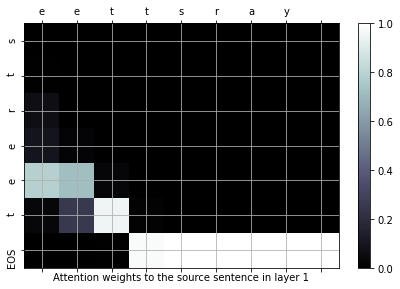

'eettsray'

In [34]:
TEST_WORD_ATTN = 'street'
visualize_attention(TEST_WORD_ATTN, rnn_attn_encoder, rnn_attn_decoder, None, rnn_attn_args)

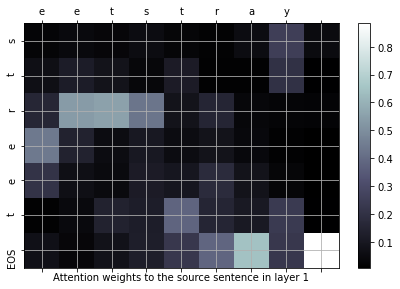

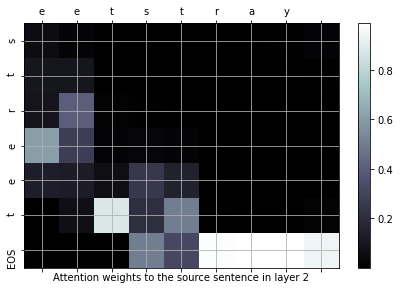

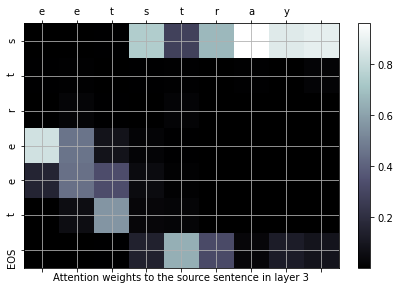

'eetstray'

In [35]:
TEST_WORD_ATTN = 'street'
visualize_attention(TEST_WORD_ATTN, trans64_encoder_l, trans64_decoder_l, None, trans64_args_l)